## Simulation of Digital Signal Processing Algorithms



The following note book is provided to simulate audio signals for the purpose of visulaising the perfomance of 
signal processing algorithms, and techniques for time difference of arrival method.




### Author: Kananelo Chabeli

### ------------------------------Imports-------------------------

In [1]:
#Imports 
import sounddevice as sd
from scipy import *
import matplotlib.pyplot as plt
import numpy as np
import wave as wv
%matplotlib inline

### Implementation of functions that read and record the wave audio files*****************

In [2]:
#define a function that reads a wave file from the given file name and returns raw wave file data and sample rate
def read_wav(filename,play=False):
    rate,data=io.wavfile.read(filename)
    if play:
        sd.play(data,rate)
    return data,rate
def record_wav(filename,duration,sampling_rate,channels=1):
    recording=sd.rec(int(duration*sampling_rate),samplerate=sampling_rate,channels=channels) #record sound
    sd.wait() #wait for the recording to complete
    io.wavfile.write(filename,sampling_rate,recording)
    return recording

### Implementation of functions that plot signals in desired domains

In [3]:
#Function that computes time axis samples for time-domain plotting
def time_axis(samples,step):
    return np.linspace(0,(samples-1)*step,int(samples))
#function that generates frequency axis samples for frequency domain plot

def freq_axis(samples,time_step):
    freq_step=1/(samples*time_step) #samples spacing in frequency domain
    if samples % 2 == 0:
       return  np.arange((-samples/2)*freq_step,((samples/2))*freq_step,freq_step)
    return np.arange((-(samples+1)/2)*freq_step,((samples-1)/2)*freq_step,freq_step)
#coming
def time_plot(t,xv,start=0,end=1000,title="Time domain plot of the signal",
              ylab="magnitudes",label="signal1",figure=1):
    if len(t)!=len(xv):
        print("Given arrays must have same dimesions!")
        return
    plt.figure(figure)
    plt.plot(t,xv,label=label)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlabel("time(s)")
    plt.show()
#coming
def spectral_plot(f,xv,time_step,title="Spectral plot of the signal",
                  ylab="magnitude",plot=True):
    if len(f) !=len(xv):
        print("Given arrays must have same dimesions!")
        return None
    XV=np.fft.fft(xv)
    XV_Abs=time_step*np.fft.fftshift(np.abs(XV))
    if plot:
        plt.plot(f,XV_Abs)
        plt.title(title)
        plt.xlabel("Frequency(Hz)")
        plt.ylabel(ylab)
        plt.show()
    return XV
#comming
def spectrogral_plot(data,rate,title="Spectrogram of the Signal"):
    f,t,Sxx=signal.spectrogram(data,rate) #Compute the spectrum
    plt.pcolormesh(t, f, Sxx) #plot the spectrum
    #plt.specgram(data,rate)
    plt.title(title)
    plt.ylabel("$Frequency(Hz)$")
    plt.xlabel("$Time(s)$")
    plt.colorbar(label="$intensity(dB)$")
    plt.show()


### Implementation of Finite Impulse Respose Low Pass Filter for Audio Signal Processing

In [4]:
#the following fucntion applies Finite Impulse Respose Filter on the signal passed and returns the filtered signal
def finite_impulse_response_filter(target_signal,cut_off,sampling_rate,length=29,width=10,response=False):
    """
        This function designs and applies a low pass Finite Impulse Respose filter
        on the target_singnal for the given sampling rate, cut_off frequency and transition region width. 
        The function plots the filter respose if the parameter 'response' is set to true, and returns the filtered signal 
    """
    #-----------------Define the Nyquist Frequency-------------
    Nyquist_rate=sampling_rate/2
    #----------------Define Normalized cut-off frequency-------
    normalized_cutoff=cut_off/Nyquist_rate
    #---------------Obtain the filter coeficients--------------
    filter_coeff=signal.firwin(length,normalized_cutoff,width=width)
    if response:
        [w,h]=signal.freqz(filter_coeff,worN=20_000)
        w=sampling_rate*w/(2*np.pi)
        h_db=20*np.log10(abs(h))
        plt.plot(w,h_db)
        plt.title("Frequency Response of the Finite Impulse Response Low Pass")
        plt.ylabel("Magnitude(dB)")
        plt.xlabel("Frequency(Hz)")
        plt.show()
    filtered_signal=signal.lfilter(filter_coeff,1.0,target_signal)
    return filtered_signal
    

## Implement Functions that perform Generalized Cross Correlation 

### 1: Generalized Cross Correlation Phase Transform : GCC-PHAT

In [5]:
def gcc_phat(reference_signal,signal,rate,interp=16):
    """
        This function takes two signals, cross-correlate them and then returns the estimated time delay between those signals.
        ---------
        Parameters:
            reference_signal(ndarray): signal taken as the reference signal
            signal(ndarray)          : signal cross_correlated with the reference signal
            rate(int)                : number of samples per seconds for the signals(signals are assumed to be 
            interp(int)              : Ineteger that control accuracy of GCC-PHAT Algorithm
        Returns:
            delay(double)            : Estimated time delay between signals
            cross_Corr(ndarray)      : Array of cross correlatio function between signal
    """
    length = signal.shape[0] + reference_signal.shape[0]
    # Generalized Cross Correlation Phase Transform
    SIGNAL = np.fft.fft(signal, n=length)
    REFERENCESIGNAL = np.fft.fft(reference_signal, n=length)
    #Compute Cross-spectral Density of the signals
    CSD = REFERENCESIGNAL * np.conj(SIGNAL)
    #Actual GCC-PHAT Alorithm
    cross_corr = np.fft.ifft(CSD / np.abs(CSD), n=(interp * length))

    max_shift = int(interp * length/ 2)
    cross_corr = np.concatenate((cross_corr[-max_shift:], cross_corr[:max_shift+1]))
    
    # find max cross correlation index
    shift = np.argmax(np.abs(cross_corr)) - max_shift
    #Find refusling time shift in seconds
    delay = shift / float(interp * rate)
    
    return np.abs(delay), cross_corr #Return absolute value of time

In [6]:
#Define function that creates a known delay of the given audio data.

def delay_audio(audio_data,rate,delay,write=False,filename='output.wav'):
    """
        This function takes audio data,sampling rate and delay is seconds.
        It created a delayed versionof the audio, delyed by the given number of seconds.
        ------------
        Parameters:
        audio_data(ndarray): raw audio data
        rate(int)          : sampling rate of the audio
        delay(double)      : Required delay is seconds
        write(bool)        : if True, resulting audio will be saved to given filename
        filename(str)      : filename of the output file, if write set to True

        Returns:
        ndarray of the  delayed data
    """
    sample_delay=int(delay*rate)
    ret=np.concatenate((np.zeros(sample_delay),audio_data)) 
    if write:
        io.wavfile.write(filename,rate,ret.astype(np.int16))
    return ret

In [18]:
data,rate=read_wav('file.wav',True)


/tmp/ipykernel_4336/1256578688.py:3: WavFileWarning: Reached EOF prematurely; finished at 11232044 bytes, expected 2147483692 bytes from header.
  rate,data=io.wavfile.read(filename)


In [10]:

channel1=data[:,0]
channel2=data[: ,1]

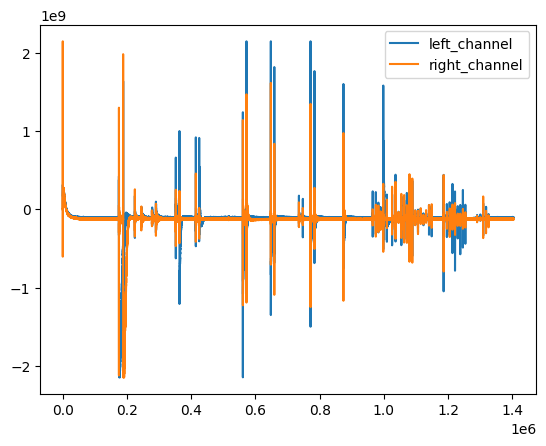

In [17]:
plt.plot(channel1,label='left_channel')
plt.plot(channel2,label='right_channel')
plt.legend()

/home/chabeli/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


delay is 0.000203125


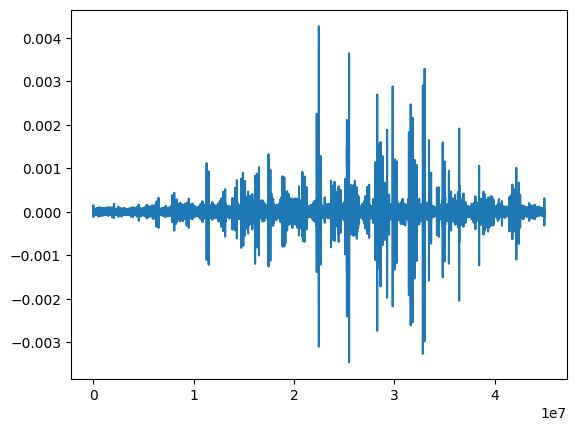

In [15]:
delay,cc=gcc_phat(channel1,channel2,rate)

plt.plot(cc)
print(f'delay is {delay}')